# Materials Discovery Workshop

This interactive notebook demonstrates how machine learning can accelerate materials discovery by learning patterns from existing alloy compositions and generating new ones.

**Workshop Goals:**
- Understand how variational autoencoders (VAEs) can model materials data
- Learn to generate new alloy compositions using ML
- Explore materials clustering and property analysis
- See how AI can accelerate materials R&D

**What you'll need:**
- Basic understanding of alloys and material properties
- Curiosity about how ML can help with materials science

Let's get started!

## Step 1: Setup and Data Loading

First, let's import the necessary libraries and load our materials dataset. This dataset contains alloy compositions and their properties.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
from typing import List, Tuple

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Running on: {'GPU' if torch.cuda.is_available() else 'CPU'}")

Libraries imported successfully!
PyTorch version: 2.9.0+cpu
Running on: CPU


In [2]:
# Load and explore the materials dataset
data = pd.read_csv('materials_dataset.csv')
print(f"Dataset shape: {data.shape}")
print("\nFirst few rows:")
data.head()

Dataset shape: (3000, 14)

First few rows:


,formula,element_1,element_2,composition_1,composition_2,melting_point,boiling_point,density,electronegativity,atomic_radius,electronegativity_difference,element_3,composition_3,alloy_type
0,Gd0.120Ni0.880,Gd,Ni,0.120009,0.879991,1795.818553,3181.832712,9356.285056,1.824794,1.404004,0.71,NaN,NaN,binary
1,Ag0.279Rh0.721,Ag,Rh,0.278569,0.721431,2256.041900,3458.041710,11625.288799,2.182501,1.419642,0.35,NaN,NaN,binary
2,Lu0.641Co0.359,Lu,Co,0.641360,0.358640,2163.799921,3773.604496,9057.353482,1.488771,1.606544,0.61,NaN,NaN,binary
3,La0.572Fe0.428,La,Fe,0.572394,0.427606,1536.325634,3321.198665,6564.252726,1.412152,1.714817,0.73,NaN,NaN,binary
4,V0.175Ti0.825,V,Ti,0.174956,0.825044,2031.328729,2895.850093,3961.658164,1.555746,1.391252,0.09,NaN,NaN,binary


In [3]:
# Explore alloy types
print("Alloy types distribution:")
print(data['alloy_type'].value_counts())

# Summary statistics
print("\nProperty statistics:")
data[['melting_point', 'density', 'electronegativity', 'atomic_radius']].describe()

Alloy types distribution:
alloy_type
binary     2000
ternary    1000
Name: count, dtype: int64

Property statistics:


,melting_point,density,electronegativity,atomic_radius
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,1772.012395,9336.240241,1.578751,1.572598
std,590.084184,4207.098411,0.323625,0.167429
min,310.508792,354.677109,0.929619,1.257643
25%,1348.522480,6575.575638,1.308748,1.428815
50%,1707.640629,8467.016185,1.551885,1.557661
75%,2115.694315,11483.514642,1.816391,1.694680
max,4543.737961,27657.561893,2.512532,2.100552


## Step 2: Data Preprocessing

We need to prepare our data for machine learning. This involves:
- Selecting relevant features
- Handling missing values
- Scaling the data

Let's focus on binary alloys for this demonstration.

In [4]:
# Select binary alloys and key features
binary_data = data[data['alloy_type'] == 'binary'].copy()
binary_data['composition_3'] = binary_data['composition_3'].fillna(0)

feature_cols = ['composition_1', 'composition_2', 'melting_point', 
               'density', 'electronegativity', 'atomic_radius']
features = binary_data[feature_cols].values

print(f"Using {len(binary_data)} binary alloys")
print(f"Feature matrix shape: {features.shape}")

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print("Features scaled successfully!")

Using 2000 binary alloys
Feature matrix shape: (2000, 6)
Features scaled successfully!


## Step 3: The Variational Autoencoder (VAE)

A VAE is a type of neural network that can learn to generate new data similar to its training data. Here's how it works:

- **Encoder**: Compresses input data into a lower-dimensional latent space
- **Latent Space**: A compressed representation where similar materials are close together
- **Decoder**: Reconstructs data from the latent space

The "variational" part means it learns a probability distribution, allowing us to sample new materials.

In [5]:
class SimpleVAE(nn.Module):
    """Simplified Variational Autoencoder for materials discovery."""

    def __init__(self, input_dim: int = 6, latent_dim: int = 5):
        super(SimpleVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_var = nn.Linear(16, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mu, log_var

print("VAE class defined successfully!")

VAE class defined successfully!


Training VAE for 50 epochs...
This may take a minute or two...


Epoch 10/50, Loss: 190.5866


Epoch 20/50, Loss: 190.4788


Epoch 30/50, Loss: 190.5102


Epoch 40/50, Loss: 190.4906


Epoch 50/50, Loss: 190.4682

VAE training completed!


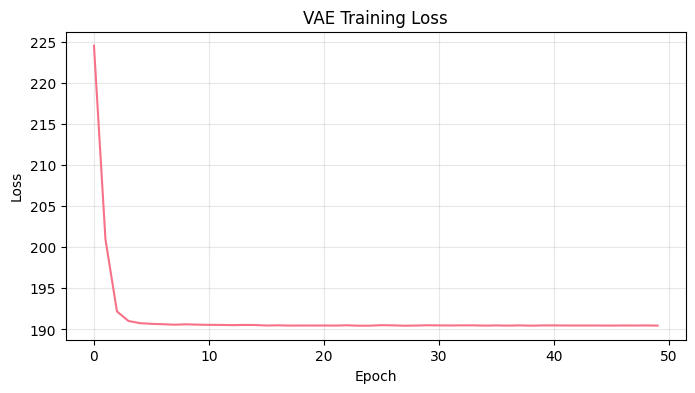

In [6]:
# Initialize and train the VAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = features_scaled.shape[1]
model = SimpleVAE(input_dim=input_dim, latent_dim=5).to(device)

# Convert data to PyTorch tensors
features_tensor = torch.FloatTensor(features_scaled)
dataset = torch.utils.data.TensorDataset(features_tensor, features_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training setup
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50  # You can adjust this

print(f"Training VAE for {epochs} epochs...")
print("This may take a minute or two...")

model.train()
losses = []

for epoch in range(epochs):
    epoch_loss = 0
    for batch_x, _ in dataloader:
        batch_x = batch_x.to(device)

        # Forward pass
        reconstructed, mu, log_var = model(batch_x)

        # Compute loss
        reconstruction_loss = nn.functional.mse_loss(reconstructed, batch_x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = reconstruction_loss + kl_loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

print("\nVAE training completed!")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

## Step 4: Generating New Materials

Now that we have a trained VAE, we can generate new materials by sampling from the latent space. This is like asking the model to "imagine" new alloys that follow the patterns it learned from existing materials.

In [7]:
# Generate new materials
model.eval()
num_samples = 100  # You can change this number

print(f"Generating {num_samples} new material compositions...")

with torch.no_grad():
    # Sample from latent space
    z = torch.randn(num_samples, model.latent_dim).to(device)
    generated_features = model.decode(z).cpu().numpy()

    # Inverse transform to original scale
    generated_features = scaler.inverse_transform(generated_features)

# Create DataFrame with generated materials
elements = ['Al', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']
new_materials = []

for i, features in enumerate(generated_features):
    elem1, elem2 = random.sample(elements, 2)
    comp1 = max(0.1, min(0.9, features[0]))
    comp2 = 1.0 - comp1
    
    material = {
        'id': f'generated_{i+1}',
        'element_1': elem1,
        'element_2': elem2,
        'composition_1': comp1,
        'composition_2': comp2,
        'formula': f'{elem1}{comp1:.3f}{elem2}{comp2:.3f}',
        'melting_point': abs(features[2]),
        'density': abs(features[3]),
        'electronegativity': max(0, features[4]),
        'atomic_radius': max(0, features[5]),
        'is_generated': True
    }
    new_materials.append(material)

generated_df = pd.DataFrame(new_materials)
print(f"Generated {len(generated_df)} new materials!")

# Show some examples
print("\nExample generated materials:")
generated_df[['formula', 'melting_point', 'density']].head(10)

Generating 100 new material compositions...
Generated 100 new materials!

Example generated materials:


,formula,melting_point,density
0,Cu0.497Ti0.503,1771.203857,9402.380859
1,Cu0.498Co0.502,1776.208008,9435.091797
2,Cr0.497Co0.503,1770.464233,9398.002930
3,Cu0.497Cr0.503,1771.025757,9401.083984
4,Al0.497Co0.503,1770.521606,9398.224609
5,Ti0.497Cu0.503,1771.256714,9403.054688
6,V0.498Ti0.502,1772.489014,9410.632812
7,V0.497Cu0.503,1770.492432,9398.395508
8,Zn0.498Cr0.502,1774.253906,9421.461914
9,Al0.497Fe0.503,1772.485718,9411.134766


## Step 5: Materials Clustering

Let's analyze the original materials by grouping them into clusters. This helps us understand natural groupings in the materials space.

In [8]:
# Perform clustering analysis
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Find optimal number of clusters
silhouette_scores = []
for n_clusters in range(2, 8):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features_pca)
    silhouette_avg = silhouette_score(features_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Optimal number of clusters: {optimal_clusters}")

# Perform clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_pca)

# Add cluster info to data
clustered_data = binary_data.copy()
clustered_data['cluster'] = cluster_labels
clustered_data['pca_1'] = features_pca[:, 0]
clustered_data['pca_2'] = features_pca[:, 1]

print(f"Materials grouped into {optimal_clusters} clusters")

Optimal number of clusters: 4
Materials grouped into 4 clusters


## Step 6: Visualizations and Analysis

Let's create visualizations to compare original and generated materials, and explore the clustering results.

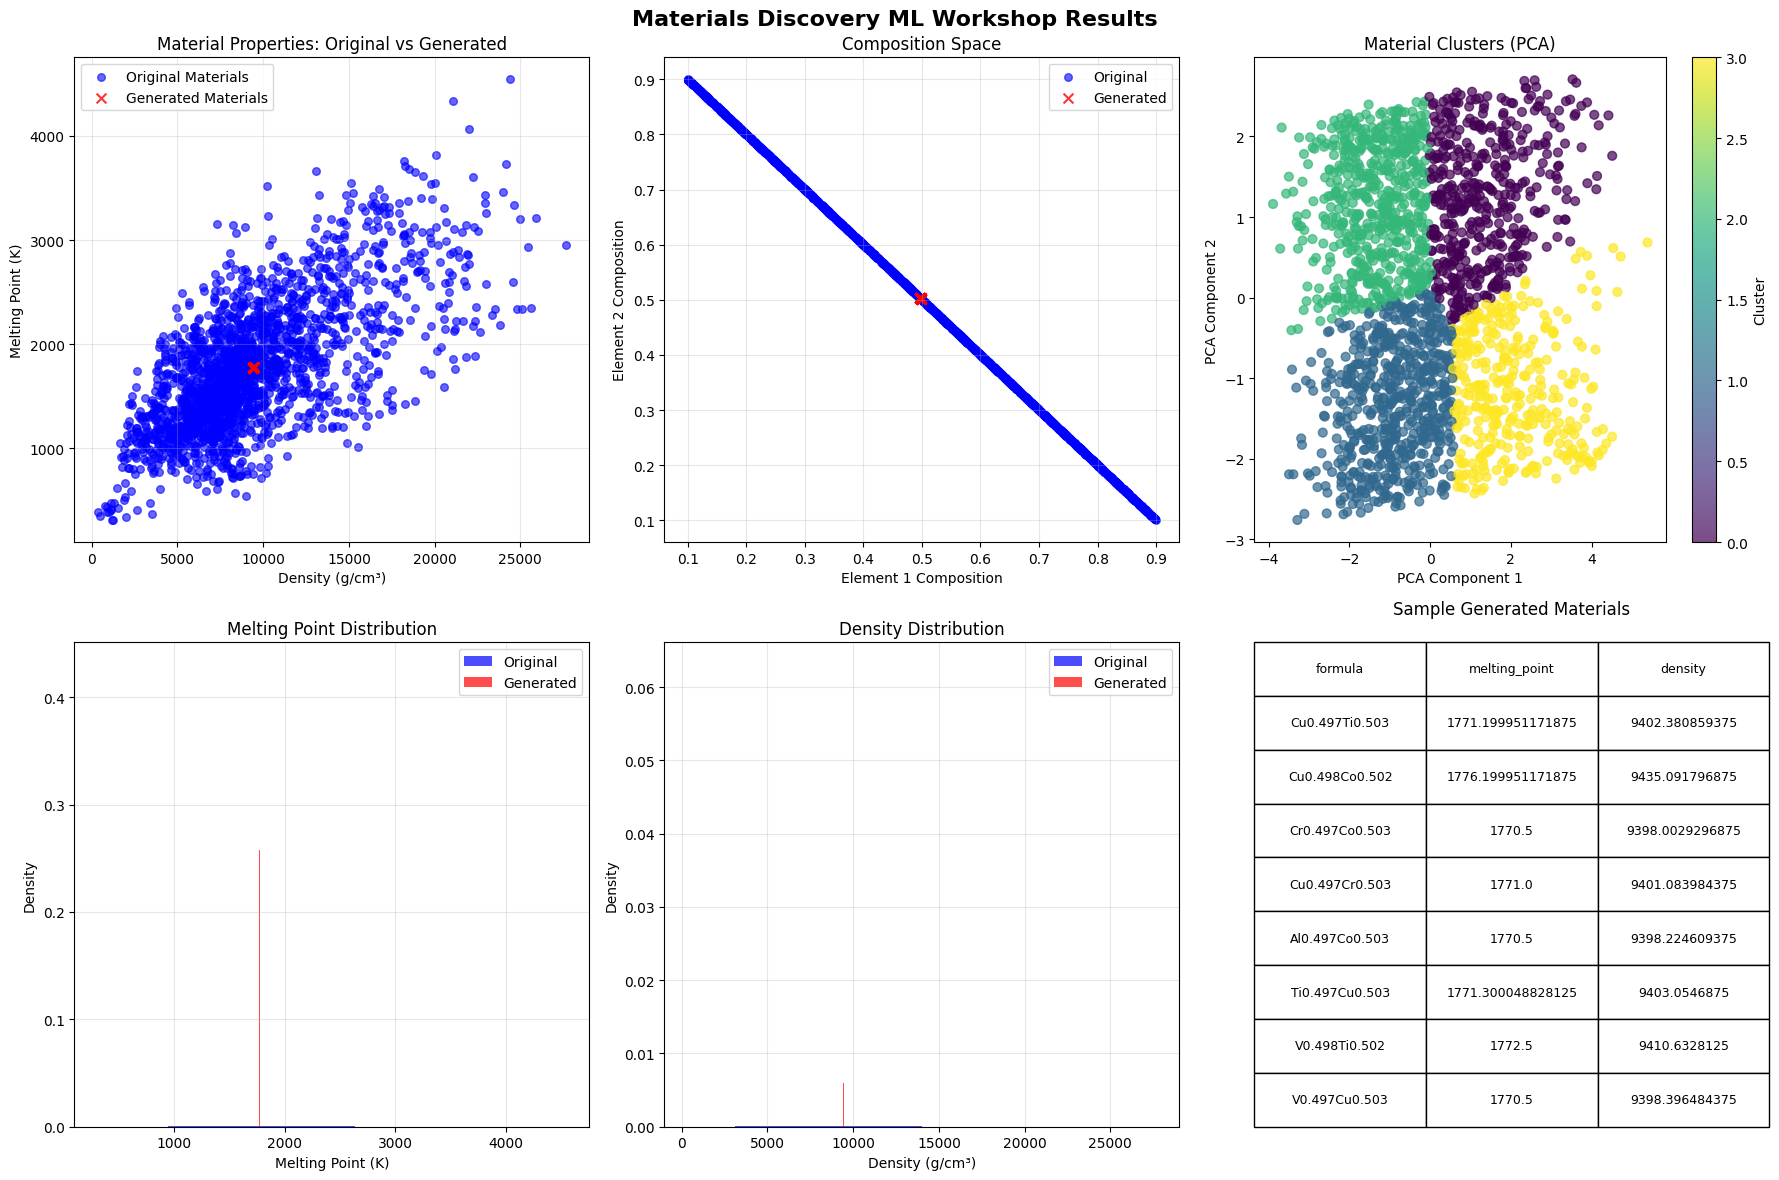

Visualization saved as 'materials_discovery_workshop.png'


In [9]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Materials Discovery ML Workshop Results', fontsize=16, fontweight='bold')

# 1. Melting Point vs Density
ax = axes[0, 0]
ax.scatter(binary_data['density'], binary_data['melting_point'], 
           alpha=0.6, c='blue', label='Original Materials', s=30)
ax.scatter(generated_df['density'], generated_df['melting_point'], 
           alpha=0.8, c='red', marker='x', label='Generated Materials', s=50)
ax.set_xlabel('Density (g/cm³)')
ax.set_ylabel('Melting Point (K)')
ax.set_title('Material Properties: Original vs Generated')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Composition Space
ax = axes[0, 1]
ax.scatter(binary_data['composition_1'], binary_data['composition_2'], 
           alpha=0.6, c='blue', label='Original', s=30)
ax.scatter(generated_df['composition_1'], generated_df['composition_2'], 
           alpha=0.8, c='red', marker='x', label='Generated', s=50)
ax.set_xlabel('Element 1 Composition')
ax.set_ylabel('Element 2 Composition')
ax.set_title('Composition Space')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Cluster Analysis
ax = axes[0, 2]
scatter = ax.scatter(clustered_data['pca_1'], clustered_data['pca_2'], 
                     c=clustered_data['cluster'], cmap='viridis', alpha=0.7, s=40)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_title('Material Clusters (PCA)')
plt.colorbar(scatter, ax=ax, label='Cluster')

# 4. Property Distributions - Melting Point
ax = axes[1, 0]
ax.hist(binary_data['melting_point'], bins=20, alpha=0.7, color='blue', 
        label='Original', density=True)
ax.hist(generated_df['melting_point'], bins=20, alpha=0.7, color='red', 
        label='Generated', density=True)
ax.set_xlabel('Melting Point (K)')
ax.set_ylabel('Density')
ax.set_title('Melting Point Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Property Distributions - Density
ax = axes[1, 1]
ax.hist(binary_data['density'], bins=20, alpha=0.7, color='blue', 
        label='Original', density=True)
ax.hist(generated_df['density'], bins=20, alpha=0.7, color='red', 
        label='Generated', density=True)
ax.set_xlabel('Density (g/cm³)')
ax.set_ylabel('Density')
ax.set_title('Density Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Generated Materials Table
ax = axes[1, 2]
ax.axis('off')
table_data = generated_df.head(8)[['formula', 'melting_point', 'density']].copy()
table_data['melting_point'] = table_data['melting_point'].round(1)
table_data['density'] = table_data['density'].round(3)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, 
                 cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)
ax.set_title('Sample Generated Materials', pad=20)

plt.tight_layout()
plt.savefig('materials_discovery_workshop.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'materials_discovery_workshop.png'")

## Step 7: Export Results

Let's save our generated materials for further analysis or fabrication testing.

In [10]:
# Save generated materials
generated_df.to_csv('generated_materials_workshop.csv', index=False)
print("Generated materials saved to 'generated_materials_workshop.csv'")

# Workshop summary
print("\n" + "="*60)
print("MATERIALS DISCOVERY WORKSHOP SUMMARY")
print("="*60)
print(f"Original materials analyzed: {len(binary_data)}")
print(f"New materials generated: {len(generated_df)}")
print(f"Material clusters identified: {optimal_clusters}")
print()
print("Key Takeaways:")
print("- ML can learn complex patterns in materials data")
print("- VAE models can generate novel material compositions")
print("- Clustering reveals natural groupings in materials space")
print("- This approach can accelerate materials R&D workflows")
print()
print("Next Steps:")
print("- Validate generated materials experimentally")
print("- Extend to ternary and higher-order alloys")
print("- Incorporate additional material properties")
print("- Use reinforcement learning for property optimization")

Generated materials saved to 'generated_materials_workshop.csv'

MATERIALS DISCOVERY WORKSHOP SUMMARY
Original materials analyzed: 2000
New materials generated: 100
Material clusters identified: 4

Key Takeaways:
- ML can learn complex patterns in materials data
- VAE models can generate novel material compositions
- Clustering reveals natural groupings in materials space
- This approach can accelerate materials R&D workflows

Next Steps:
- Validate generated materials experimentally
- Extend to ternary and higher-order alloys
- Incorporate additional material properties
- Use reinforcement learning for property optimization


## Workshop Exercises

Try these modifications to deepen your understanding:

1. **Change the latent dimension**: Modify the `latent_dim` parameter in the VAE. How does this affect the generated materials?

2. **Adjust training epochs**: Try training for more or fewer epochs. What's the impact on the loss curve and generated materials?

3. **Generate more samples**: Increase `num_samples` to create a larger library of candidate materials.

4. **Explore different elements**: Modify the `elements` list to include different metals or add non-metals.

5. **Analyze specific clusters**: Use the cluster labels to analyze what makes materials in different clusters unique.

**Remember**: The goal is to generate materials that are novel but still physically reasonable. Always validate ML-generated candidates experimentally!